# Scikit-Opt of WBF params for EfficientDet

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernels for this competition:

- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)
- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)
- [[Inference] EfficientDet](https://www.kaggle.com/shonenkov/inference-efficientdet)
- [[OOF-Evaluation][Mixup] EfficientDet](https://www.kaggle.com/shonenkov/oof-evaluation-mixup-efficientdet)

Thank you all, my friends, for your support, I appreciate it.

# Main Idea

Recently I have got boost for this competition using WBF. I used params such as used in paper, but I decided to optimize these params for effdet. It gives me good boost also. 


I would like to share with you my work about it.


In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import os
from ensemble_boxes import *
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from tqdm import tqdm
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize, forest_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, plot_regret
from skopt.space import Categorical, Integer, Real

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [3]:
USE_OPTIMIZE = len(glob(f'../input/global-wheat-detection/test/*.jpg')) == 10
USE_OPTIMIZE # used for fast inference in submission

True

# Prepare Folds

I have used holdout fold for optimizing. Here you can see used splitting.

In [4]:
marking = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [5]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']]
df_folds['bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds['source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds['stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

train_index, holdout_index = next(skf.split(X=df_folds.index, y=df_folds['stratify_group']))
df_holdout = df_folds.iloc[holdout_index].copy()
df_folds = df_folds.iloc[train_index].copy()

df_folds['fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


CPU times: user 680 ms, sys: 37.7 ms, total: 717 ms
Wall time: 662 ms


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


# Holdout Dataset

In [6]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

def collate_fn(batch):
    return tuple(zip(*batch))

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image, boxes = self.load_image_and_boxes(index)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

In [7]:
holdout_dataset = DatasetRetriever(
    image_ids=df_holdout.index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

holdout_loader = DataLoader(
    holdout_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

# Load Models

For prediction of holdout fold I have trained the another remaining 5folds  

In [8]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint)

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

if USE_OPTIMIZE:
    models = [
        load_net('../input/wheat-skopt-holdout-effdet5-folds/fold0-best.bin'),
        load_net('../input/wheat-skopt-holdout-effdet5-folds/fold1-best.bin'),
        load_net('../input/wheat-skopt-holdout-effdet5-folds/fold2-best.bin'),
        load_net('../input/wheat-skopt-holdout-effdet5-folds/fold3-best.bin'),
        load_net('../input/wheat-skopt-holdout-effdet5-folds/fold4-best.bin'),
    ]

# Holdout Prediction

Lets make prediction of holdout fold, just like hidden test in this competition. Models didn't use holdout data for training!

In [9]:
def process_det(index, det, score_threshold=0.25):
    boxes = det[index].detach().cpu().numpy()[:,:4]    
    scores = det[index].detach().cpu().numpy()[:,4]
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
    boxes = (boxes*2).clip(min=0, max=1023).astype(int)
    indexes = np.where(scores>score_threshold)
    boxes = boxes[indexes]
    scores = scores[indexes]
    return boxes, scores


if USE_OPTIMIZE:
    all_predictions = []

    for images, targets, image_ids in tqdm(holdout_loader, total=len(holdout_loader)):
        with torch.no_grad():
            images = torch.stack(images)
            images = images.cuda().float()

            fold_predictions = {}
            for fold_number in range(5):
                fold_predictions[fold_number] = models[fold_number](images, torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                image_predictions = {
                    'image_id': image_ids[i],
                    'gt_boxes': (targets[i]['boxes'].cpu().numpy()*2).clip(min=0, max=1023).astype(int),
                }
                for fold_number in range(5):
                    boxes, scores = process_det(i, fold_predictions[fold_number])
                    image_predictions[f'pred_boxes_fold{fold_number}'] = boxes
                    image_predictions[f'scores_fold{fold_number}'] = scores

                all_predictions.append(image_predictions)

100%|██████████| 169/169 [02:20<00:00,  1.20it/s]


# Evaluation

Here I have used [really good evaluation scripts](https://www.kaggle.com/pestipeti/competition-metric-details-script) by [Peter](https://www.kaggle.com/pestipeti), I recommend to use it! 

In [10]:
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{TRAIN_ROOT_PATH}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")
    
# Numba typed list!
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [11]:
def calculate_final_score(
    all_predictions,
    iou_thr,
    skip_box_thr,
    method, # weighted_boxes_fusion, nms, soft_nms, non_maximum_weighted
    sigma=0.5,
):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        image_id = all_predictions[i]['image_id']
        folds_boxes, folds_scores, folds_labels = [], [], []
        for fold_number in range(5):
            pred_boxes = all_predictions[i][f'pred_boxes_fold{fold_number}'].copy()
            scores = all_predictions[i][f'scores_fold{fold_number}'].copy()
            folds_boxes.append(pred_boxes)
            folds_scores.append(scores)
            folds_labels.append(np.ones(pred_boxes.shape[0]))
        
        if method == 'weighted_boxes_fusion':
            boxes, scores, labels = weighted_boxes_fusion(folds_boxes, folds_scores, folds_labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        elif method == 'nms':
            boxes, scores, labels = nms(folds_boxes, folds_scores, folds_labels, weights=None, iou_thr=iou_thr)
        elif method == 'soft_nms':
            boxes, scores, labels = soft_nms(folds_boxes, folds_scores, folds_labels, weights=None, iou_thr=iou_thr, thresh=skip_box_thr, sigma=sigma)
        elif method == 'non_maximum_weighted':
            boxes, scores, labels = non_maximum_weighted(folds_boxes, folds_scores, folds_labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
        else:
            raise
        image_precision = calculate_image_precision(gt_boxes, boxes, thresholds=iou_thresholds, form='pascal_voc')
        final_scores.append(image_precision)

    return np.mean(final_scores)

In [12]:
%%time

# standart params as here https://github.com/ZFTurbo/Weighted-Boxes-Fusion
if USE_OPTIMIZE:
    print('[WBF]: ', calculate_final_score(
        all_predictions, 
        iou_thr=0.55,
        skip_box_thr=0.0001,
        method='weighted_boxes_fusion',
    ))
    print('[NMS]: ', calculate_final_score(
        all_predictions, 
        iou_thr=0.55,
        skip_box_thr=0.0001,
        method='nms',
    ))
    print('[SOFT NMS]: ', calculate_final_score(
        all_predictions, 
        iou_thr=0.55,
        skip_box_thr=0.0001,
        sigma=0.1,
        method='soft_nms',
    ))
    print('[NMW]: ', calculate_final_score(
        all_predictions, 
        iou_thr=0.55,
        skip_box_thr=0.0001,
        method='non_maximum_weighted',
    ))

[WBF]:  0.6231700561021581
[NMS]:  0.6192152534166921
[SOFT NMS]:  0.4180538933047459
[NMW]:  0.6235116712427927
CPU times: user 2min 56s, sys: 349 ms, total: 2min 56s
Wall time: 2min 57s


# [Bayesian optimization using Gaussian Processes](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html)

In [13]:
def log(text):
    with open('opt.log', 'a+') as logger:
        logger.write(f'{text}\n')

def optimize(space, all_predictions, method, n_calls=10):
    @use_named_args(space)
    def score(**params):
        log('-'*5 + f'{method}' + '-'*5)
        log(params)
        final_score = calculate_final_score(all_predictions, method=method, **params)
        log(f'final_score = {final_score}')
        log('-'*10)
        return -final_score

    return gp_minimize(func=score, dimensions=space, n_calls=n_calls)

# NMS

In [14]:
%%time

space = [
    Real(0, 1, name='iou_thr'),
    Real(0.0, 1, name='skip_box_thr'),
]

if USE_OPTIMIZE:
    opt_result = optimize(
        space, 
        all_predictions,
        method='nms',
        n_calls=50,
    )

CPU times: user 2min 1s, sys: 206 ms, total: 2min 1s
Wall time: 2min 2s


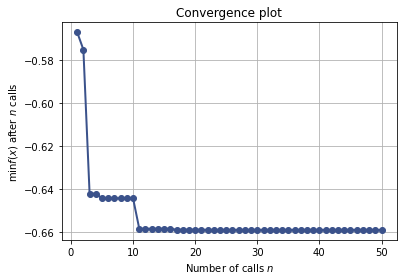

In [15]:
if USE_OPTIMIZE:
    plot_convergence(opt_result);

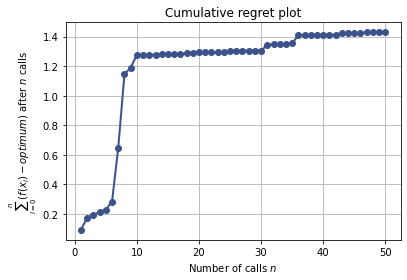

In [16]:
if USE_OPTIMIZE:
    plot_regret(opt_result);

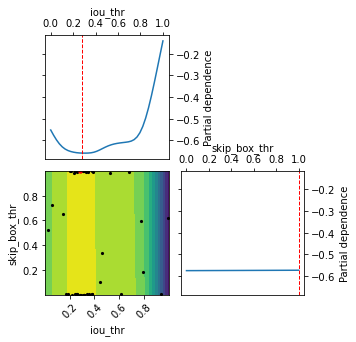

In [17]:
if USE_OPTIMIZE:
    plot_objective(opt_result);

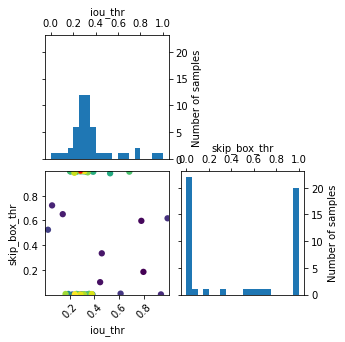

In [18]:
if USE_OPTIMIZE:
    plot_evaluations(opt_result);

In [19]:
if USE_OPTIMIZE:
    best_final_score = -opt_result.fun
    best_iou_thr = opt_result.x[0]
    best_skip_box_thr = opt_result.x[1]
    print('-'*13 + 'NMS' + '-'*14)
    print(f'[Best Iou Thr]: {best_iou_thr:.3f}')
    print(f'[Best Skip Box Thr]: {best_skip_box_thr:.3f}')
    print(f'[Best Score]: {best_final_score:.4f}')
    print('-'*30)

-------------NMS--------------
[Best Iou Thr]: 0.279
[Best Skip Box Thr]: 1.000
[Best Score]: 0.6591
------------------------------


# Soft NMS

In [20]:
%%time

space = [
    Real(0, 1, name='iou_thr'),
    Real(0.0, 1, name='skip_box_thr'),
    Real(0.0, 1, name='sigma'),
]

if USE_OPTIMIZE:
    opt_result = optimize(
        space, 
        all_predictions,
        method='soft_nms',
        n_calls=50,
    )

../input/weightedboxesfusion/ensemble_boxes/ensemble_boxes_nms.py:77: RuntimeWarning: divide by zero encountered in true_divide
  weight = np.exp(-(ovr * ovr) / sigma)
../input/weightedboxesfusion/ensemble_boxes/ensemble_boxes_nms.py:77: RuntimeWarning: invalid value encountered in true_divide
  weight = np.exp(-(ovr * ovr) / sigma)
../input/weightedboxesfusion/ensemble_boxes/ensemble_boxes_nms.py:85: RuntimeWarning: invalid value encountered in greater
  inds = dets[:, 4][scores > thresh]
../input/weightedboxesfusion/ensemble_boxes/ensemble_boxes_nms.py:77: RuntimeWarning: divide by zero encountered in true_divide
  weight = np.exp(-(ovr * ovr) / sigma)
../input/weightedboxesfusion/ensemble_boxes/ensemble_boxes_nms.py:77: RuntimeWarning: invalid value encountered in true_divide
  weight = np.exp(-(ovr * ovr) / sigma)
../input/weightedboxesfusion/ensemble_boxes/ensemble_boxes_nms.py:85: RuntimeWarning: invalid value encountered in greater
  inds = dets[:, 4][scores > thresh]
../input/w

CPU times: user 11min 38s, sys: 779 ms, total: 11min 39s
Wall time: 11min 42s


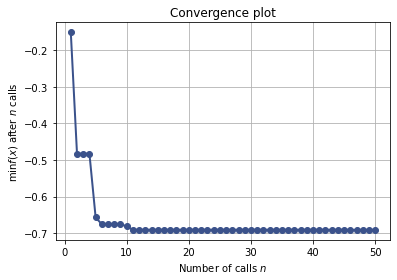

In [21]:
if USE_OPTIMIZE:
    plot_convergence(opt_result);

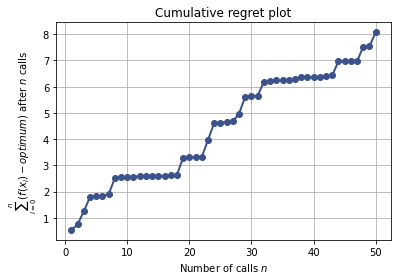

In [22]:
if USE_OPTIMIZE:
    plot_regret(opt_result);

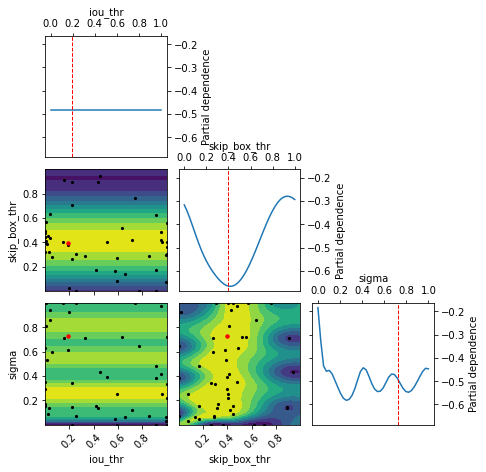

In [23]:
if USE_OPTIMIZE:
    plot_objective(opt_result);

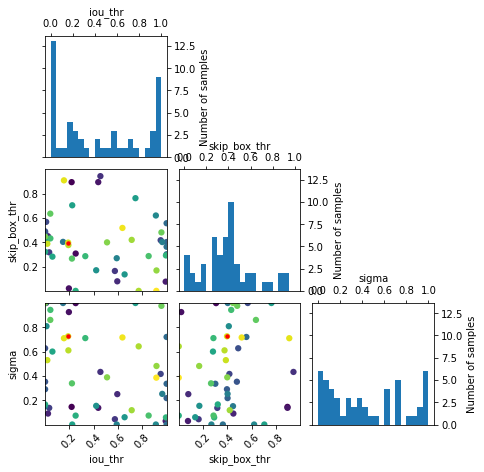

In [24]:
if USE_OPTIMIZE:
    plot_evaluations(opt_result);

In [25]:
if USE_OPTIMIZE:
    best_final_score = -opt_result.fun
    best_iou_thr = opt_result.x[0]
    best_skip_box_thr = opt_result.x[1]
    best_sigma = opt_result.x[2]
    print('-'*11 + 'SOFT NMS' + '-'*11)
    print(f'[Best Iou Thr]: {best_iou_thr:.3f}')
    print(f'[Best Skip Box Thr]: {best_skip_box_thr:.3f}')
    print(f'[Best Sigma]: {best_sigma:.3f}')
    print(f'[Best Score]: {best_final_score:.4f}')
    print('-'*30)

-----------SOFT NMS-----------
[Best Iou Thr]: 0.190
[Best Skip Box Thr]: 0.397
[Best Sigma]: 0.726
[Best Score]: 0.6913
------------------------------


# NMW

In [26]:
%%time

space = [
    Real(0, 1, name='iou_thr'),
    Real(0.0, 1, name='skip_box_thr'),
]

if USE_OPTIMIZE:
    opt_result = optimize(
        space, 
        all_predictions,
        method='non_maximum_weighted',
        n_calls=50,
    )

CPU times: user 27min 57s, sys: 5.33 s, total: 28min 2s
Wall time: 28min 6s


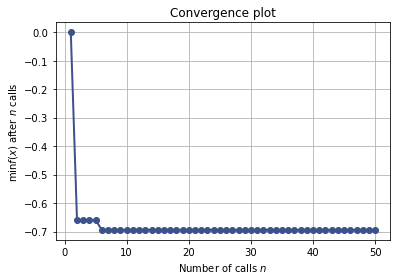

In [27]:
if USE_OPTIMIZE:
    plot_convergence(opt_result);

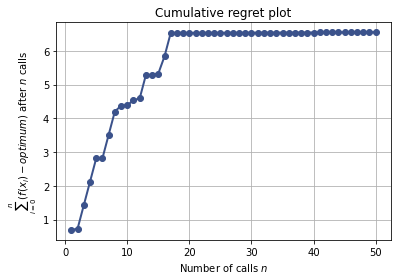

In [28]:
if USE_OPTIMIZE:
    plot_regret(opt_result);

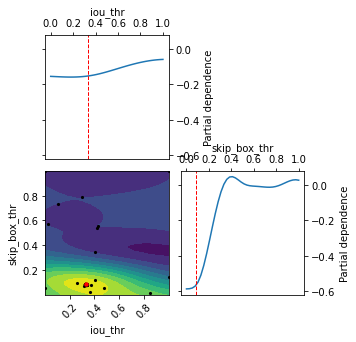

In [29]:
if USE_OPTIMIZE:
    plot_objective(opt_result);

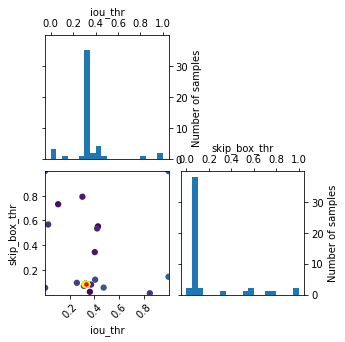

In [30]:
if USE_OPTIMIZE:
    plot_evaluations(opt_result);

In [31]:
if USE_OPTIMIZE:
    best_final_score = -opt_result.fun
    best_iou_thr = opt_result.x[0]
    best_skip_box_thr = opt_result.x[1]
    print('-'*13 + 'NMW' + '-'*14)
    print(f'[Best Iou Thr]: {best_iou_thr:.3f}')
    print(f'[Best Skip Box Thr]: {best_skip_box_thr:.3f}')
    print(f'[Best Score]: {best_final_score:.4f}')
    print('-'*30)

-------------NMW--------------
[Best Iou Thr]: 0.332
[Best Skip Box Thr]: 0.085
[Best Score]: 0.6944
------------------------------


# WBF

In [32]:
%%time

space = [
    Real(0, 1, name='iou_thr'),
    Real(0.25, 1, name='skip_box_thr'),
]

if USE_OPTIMIZE:
    opt_result = optimize(
        space, 
        all_predictions,
        method='weighted_boxes_fusion',
        n_calls=50,
    )

CPU times: user 55min 24s, sys: 3.95 s, total: 55min 28s
Wall time: 55min 46s


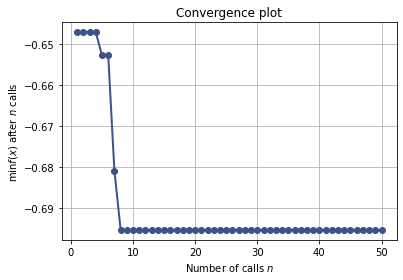

In [33]:
if USE_OPTIMIZE:
    plot_convergence(opt_result);

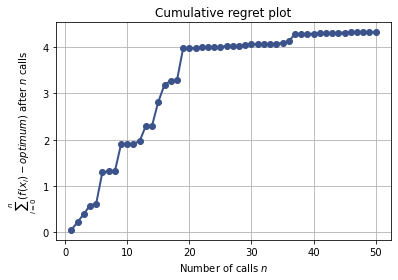

In [34]:
if USE_OPTIMIZE:
    plot_regret(opt_result);

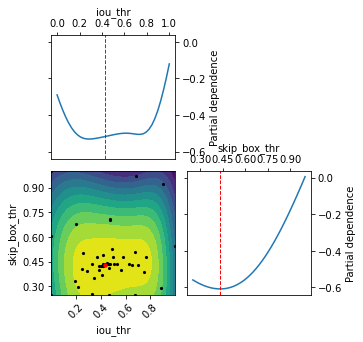

In [35]:
if USE_OPTIMIZE:
    plot_objective(opt_result);

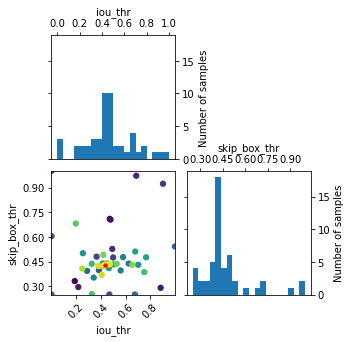

In [36]:
if USE_OPTIMIZE:
    plot_evaluations(opt_result);

In [37]:
if USE_OPTIMIZE:
    best_final_score = -opt_result.fun
    best_iou_thr = opt_result.x[0]
    best_skip_box_thr = opt_result.x[1]
else:
    # calculated early for fast inference in submission [see version 1 with n_calls=300]
    best_final_score = 0.6953
    best_iou_thr = 0.44
    best_skip_box_thr = 0.43

print('-'*13 + 'WBF' + '-'*14)
print(f'[Best Iou Thr]: {best_iou_thr:.3f}')
print(f'[Best Skip Box Thr]: {best_skip_box_thr:.3f}')
print(f'[Best Score]: {best_final_score:.4f}')
print('-'*30)

-------------WBF--------------
[Best Iou Thr]: 0.430
[Best Skip Box Thr]: 0.430
[Best Score]: 0.6953
------------------------------


# Inference with best barams

In [38]:
models = [
    load_net('../input/effdet5-folds-v2/fold0-best.bin'),
    load_net('../input/effdet5-folds-v2/fold1-best.bin'),
    load_net('../input/effdet5-folds-v2/fold2-best.bin'),
    load_net('../input/effdet5-folds-v2/fold3-best.bin'),
    load_net('../input/effdet5-folds-v2/fold4-best.bin'),
    load_net('../input/effdet5-folds-mixup/fold0-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold1-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold2-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold3-best-v2.bin'),
    load_net('../input/effdet5-folds-mixup/fold4-best-v2.bin'),
]

In [39]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class TestDatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
    )

dataset = TestDatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

def make_predictions(
    images, 
    score_threshold=0.25,
):
    images = torch.stack(images).cuda().float()
    predictions = []
    for fold_number, net in enumerate(models):
        with torch.no_grad():
            det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
            result = []
            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                result.append({
                    'boxes': boxes[indexes],
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions


def run_wbf(predictions, image_index, image_size=512, iou_thr=best_iou_thr, skip_box_thr=best_skip_box_thr, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels


def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)


results = []

for images, image_ids in data_loader:
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)
        
        
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)

# Thank you for reading my kernel!